SMITE is a third-person MOBA developed by Titan Forge Games. In the primary competitive mode of SMITE, players on teams of five select combinations of deities from a pool of over 100, and then must choose 6 items to purchase from a pool of over 250+ items throughout the game. This project focuses on the second of these challenges, attempting to provide a beginner-friendly guide to which items are currently performing well on particular deities.

There is a plethora of information available from SMITE's developer API, including kills, deaths, and assists, damage dealt, taken, and mitigated, and team and self healing. To begin, I will explore the connections between a player's performance statistics and their likelihood of victory.

I will investigate both engineered features (such as K+A / D, or DM + SH / DT, or any other interesting combinations) alongside the raw features themselves to see if there is a linear or nonlinear relationship between these features and victory.

Next, I will explore the relationship between a player's performance and the items they ended the game with. While I cannot see the items purchased or sold throughout the game, the structure of the in-game economy discourages selling most purchased items. As such, this is the highest resolution data available. Additionally, I prune my information (restricting to t3+ items) to prevent skewing.

In [1]:
from smitebuilder.etl import get_matchdata
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np

In [2]:
raw_data = get_matchdata('P:/SmiteData/conquest_match_data/1649.json')
col_names = (
    'BIAS', 
    'assists', 
    'damage_mitigated', 
    'damage_player', 
    'damage_taken', 
    'deaths', 
    'healing', 
    'healing_player_self', 
    'kills_player', 
    'structure_damage', 
    'net_damage_taken',
    'win_status',
)
player_damage = [x['damage_player'] for x in raw_data]
pd_10 = np.percentile(player_damage, 10)
data = np.array(
    [
        np.divide(
            np.array(
                [
                    x["assists"],
                    x["damage_mitigated"],
                    x["damage_player"],
                    x["damage_taken"],
                    x["deaths"],
                    x["healing"],
                    x["healing_player_self"],
                    x["kills_player"],
                    x["structure_damage"],
                    ((x["damage_mitigated"] + x["healing_player_self"] - x["damage_taken"]) / (x["damage_player"] if x["damage_player"] != 0 else 1)),
                ]
            ),
            x["match_time_minutes"],
        )
        for x in raw_data if x["damage_player"] > pd_10
    ]
)
scaler = StandardScaler(copy=False)
scaler.fit_transform(data)
bias = np.ones((data.shape[0], 1))
win_label = np.array([1 if x["win_status"] == "Winner" else 0 for x in raw_data if x["damage_player"] > pd_10]).reshape(data.shape[0], 1)
data = np.hstack((bias, data, win_label))
df = pd.DataFrame(data, columns=col_names)

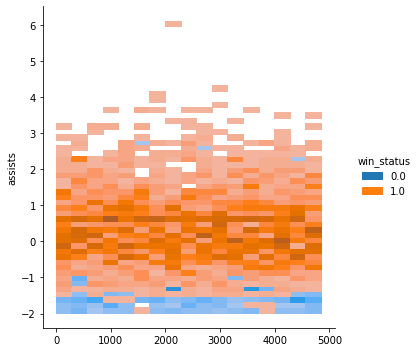

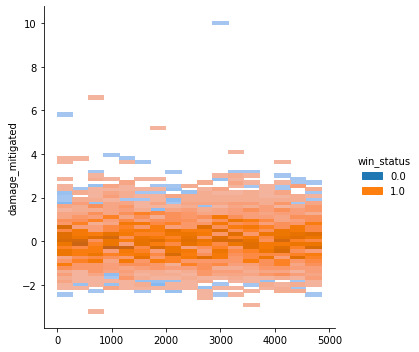

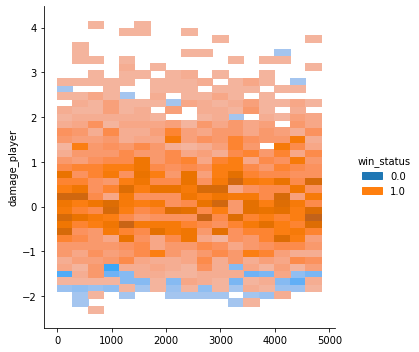

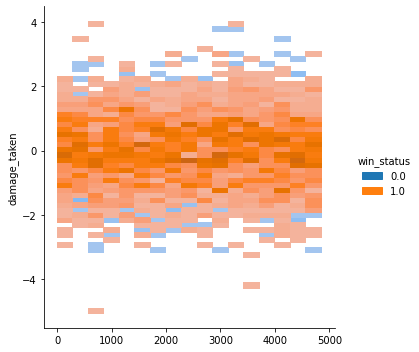

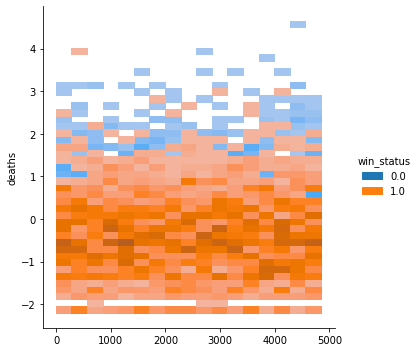

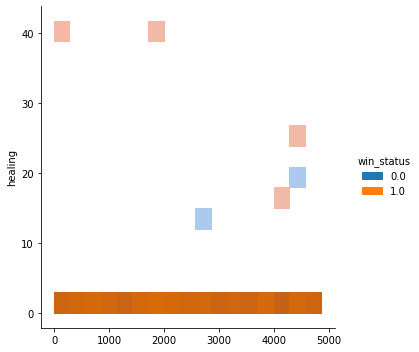

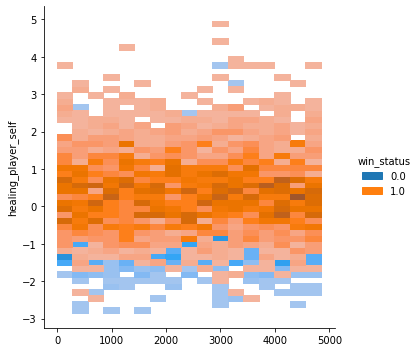

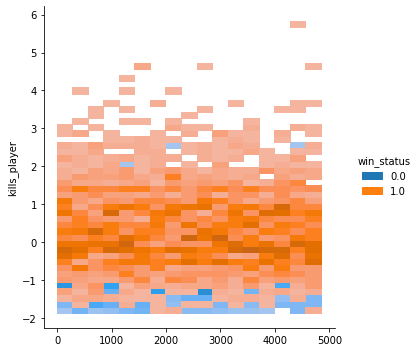

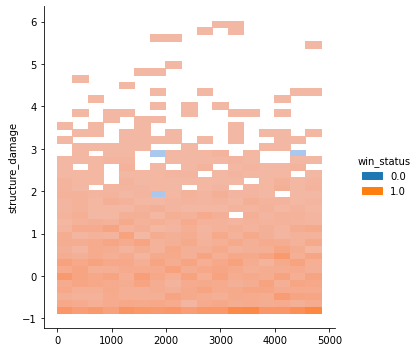

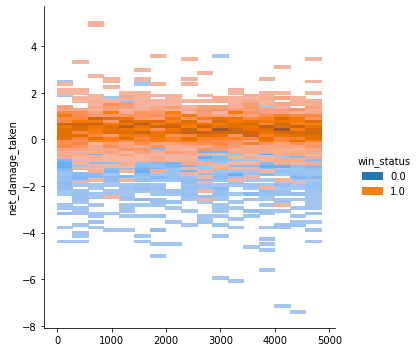

In [3]:
# First, let's plot our raw features to see any visual correlations between them and victory
for col in col_names:
    if col == 'BIAS' or col == 'win_status':
        continue
    sbn.displot(data=df, x=df.index, y=col, hue='win_status')

In [22]:
# Let's experiment with some engineered features

# Damage Mitigated + Self Heal == Net Damage Resisted
# Net Damage Resisted / Damage Taken
# Damage Dealt vs Damage Taken
# Net Damage Resisted - Damage Taken == Net Damage Taken (maybe for tanks?)
# NDT vs Damage Dealt?

In [5]:
two_d = TSNE(random_state=0).fit_transform(data[:,1:-1])

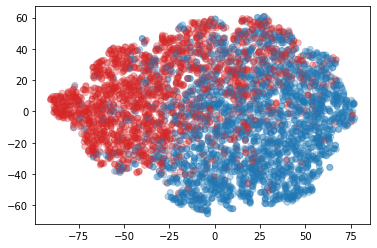

In [6]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in win_label]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [13]:
svm = SVC(kernel='poly', random_state=0)
svm.fit(data[:,:-1], win_label.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
new_l = svm.predict(data[:,:-1])
svm.score(data[:,:-1], win_label)

0.8439687114038699

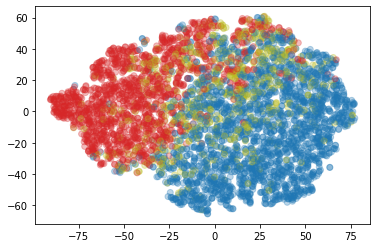

In [16]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if win_label[idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [17]:
sgdc = SGDClassifier(random_state=0)
sgdc.fit(data[:,:-1], win_label.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
new_l = sgdc.predict(data[:,:-1])
sgdc.score(data[:,:-1],win_label)

0.8295594895018527

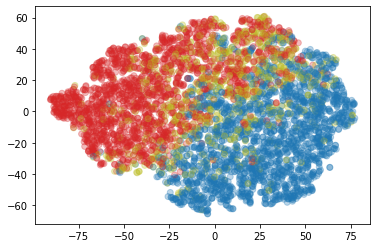

In [19]:
plt.cla()
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e == 1 else 'tab:red' for e in new_l]
c = [e if win_label[idx] == new_l[idx] else 'tab:olive' for idx,e in enumerate(c)]
plt.scatter(x,y, c=c, alpha=0.3)
# plt.legend()
plt.show()

In [20]:
[x for x in sgdc.coef_[0]]

[-0.6494252586460898,
 0.9286788048617429,
 -0.5095602836570353,
 0.19162531916640657,
 -0.39668179226071293,
 -0.24393439070299808,
 0.0020102339555917903,
 0.6385656866824296,
 0.3773719954804552,
 1.1855592770183954,
 0.5016369261399306]

First, I will do some visual exploration of the data, examining the characteristics of each statistic and how it correlates to victory for a particular diety. Once the structure is complete, I intend to check it out with one diety of each class.

Next, I'd like to determine whether a linear fitter will work for the data or if a non-linear model is required. SGDC for linear, SVMC for non-linear.

After that, I need to determine if / how any data adjustment / de-fuzzing affects the final item classification accuracy. (essentially, does "correcting" the performance data labelling favorably impact the item classification accuracy?)

After that, maybe explore different classifiers for items and performance, see if you can accurately determine the performance statistics based upon the items (this would prove the performance / item correlation)